In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform
import os

In [3]:
class_names = [str(i) for i in range(10)]
# class_names.append('a')
# class_names.append('b')

In [4]:
IMAGE_DIRECTORY = "../Datasets/HandWritten-Nist/dataset"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
	IMAGE_DIRECTORY,
	labels="inferred",
	label_mode="categorical", # one-hot encoding stuff
	image_size=(128, 128),
	shuffle=True,
	color_mode="grayscale"
)

# Split to train and test 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)


Found 425122 files belonging to 47 classes.


I0000 00:00:1732039241.333677    1026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732039243.352590    1026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732039243.352667    1026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732039243.381736    1026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732039243.381861    1026 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
# Normalize the dataset prior to the model

def normalize(image, label):
	image = tf.cast(image, tf.float32) / 255.0
	return image, label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)

In [6]:
# # Configuring the dataset for performance
# # Enable caching and prefetching (overlap preprocessing and model execution while training)
# AUTOTUNE = tf.data.AUTOTUNE

# # Set up a pre-processing function. It is just going to be normalizing here, but
# # that hopefully should save time later?
# def preprocess_image(image, label):
# 	image = image / 255.0
# 	return image, label

# # Cache to disk instead of memory because we got some large datasets
# dataset = dataset.cache('/tmp/dataset_cache')

# # Apply preprocessing
# # dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Prefetching..? Gotta be honest, this seems to help but idk how considering all
# # the images are local
# dataset = dataset.prefetch(buffer_size=2)

# train_ds = dataset.shuffle(1000)

# # train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # train_ds = dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache('/tmp/dataset_cache')
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(buffer_size=2)

In [8]:
# print(train_dataset.class_names)
# labels = tf.keras.utils.to_categorical()

In [ ]:
model = tf.keras.models.Sequential()
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 1

# # Standardize. Bring it down from 0..255 to [0,1] range
# model.add(tf.keras.layers.Rescaling(
# 	scale=1./255,
#     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
# ))

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling(),
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

# Output layer
model.add(tf.keras.layers.Dense(
    units=47,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

/home/nuttynoah/Downloads/Handwriting-Recognition-CS584/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,722,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,983 (6.61 MB)

 Trainable params: 1,731,983 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model

# Uses Adam. Adam works by
# - Keeping track of a history of gradients as opposed to just the current
#   gradient
# - It uses an adaptive learning rate based on that gradient history Adam is

# It also just generally efficient and works well for our use case (ChatGPT
# mentions good for computer vision tasks which is kind of what we are doing)

# We might try testing this with stochastic gradient descent instead because
# that is what we learned in class. We could use that as a storytelling aspect
# for the professor

# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# model.compile(
#     optimizer=adam_optimizer,
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

sgd_optimizer = tf.keras.optimizers.SGD()
model.compile(
	optimizer=sgd_optimizer,
	loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    train_dataset,
    # y_train_re,
    epochs=5,
    # validation_data=(x_validation_normalized, y_validation_re),
    validation_data=val_dataset
    # callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/5


I0000 00:00:1732039395.723508    1609 service.cc:146] XLA service 0x7fccc0007170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732039395.723545    1609 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


   23/10628 ━━━━━━━━━━━━━━━━━━━━ 1:10 7ms/step - accuracy: 0.0343 - loss: 3.8405     

I0000 00:00:1732039421.588036    1609 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10628/10628 ━━━━━━━━━━━━━━━━━━━━ 1911s 164ms/step - accuracy: 0.6014 - loss: 1.4543 - val_accuracy: 0.8570 - val_loss: 0.4468
Epoch 2/5
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 738s 66ms/step - accuracy: 0.8415 - loss: 0.5012 - val_accuracy: 0.8813 - val_loss: 0.3631
Epoch 3/5
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 766s 69ms/step - accuracy: 0.8636 - loss: 0.4223 - val_accuracy: 0.8940 - val_loss: 0.3220
Epoch 4/5
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 759s 67ms/step - accuracy: 0.8739 - loss: 0.3829 - val_accuracy: 0.8997 - val_loss: 0.2985
Epoch 5/5
10628/10628 ━━━━━━━━━━━━━━━━━━━━ 738s 66ms/step - accuracy: 0.8829 - loss: 0.3556 - val_accuracy: 0.9067 - val_loss: 0.2781
The model has successfully trained


In [13]:
# Access training loss and accuracy
train_loss = training_history.history['loss']
train_accuracy = training_history.history['accuracy']

# Access validation loss and accuracy (if validation data is provided)
val_loss = training_history.history.get('val_loss')
val_accuracy = training_history.history.get('val_accuracy')

# Print statistics for each epoch
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss[epoch]:.4f}, Training Accuracy: {train_accuracy[epoch]:.4f}")
    if val_loss and val_accuracy:
        print(f"  Validation Loss: {val_loss[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1:
  Training Loss: 0.8898, Training Accuracy: 0.7398
  Validation Loss: 0.4468, Validation Accuracy: 0.8570
Epoch 2:
  Training Loss: 0.4793, Training Accuracy: 0.8478
  Validation Loss: 0.3631, Validation Accuracy: 0.8813
Epoch 3:
  Training Loss: 0.4132, Training Accuracy: 0.8660
  Validation Loss: 0.3220, Validation Accuracy: 0.8940
Epoch 4:
  Training Loss: 0.3773, Training Accuracy: 0.8757
  Validation Loss: 0.2985, Validation Accuracy: 0.8997
Epoch 5:
  Training Loss: 0.3512, Training Accuracy: 0.8834
  Validation Loss: 0.2781, Validation Accuracy: 0.9067


In [ ]:
model_name_string = "model_v3"

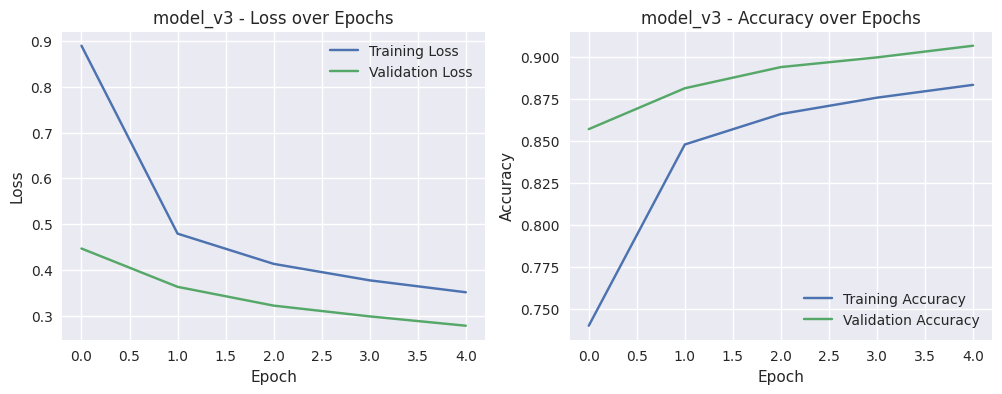

In [28]:
import matplotlib.pyplot as plt


# Plot training and validation loss

with plt.style.context("seaborn-v0_8"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['loss'], label='Training Loss')
    if 'val_loss' in training_history.history:
        plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name_string} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in training_history.history:
        plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name_string} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.style.use('seaborn-v0_8-bright')
    plt.legend()

    plt.show()

In [16]:
import pandas as pd

# Convert the history to a DataFrame and save as CSV
history_df = pd.DataFrame(training_history.history)
history_df.to_csv(f'{model_name_string}_history.csv', index=False)

In [17]:
# Save the model itself
model.save(f'{model_name_string}.keras')

In [18]:
# Save model weights
model.save_weights(f'{model_name_string}.weights.h5') 